In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE
import warnings
from aim2functions import *
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/jiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import os
import sys
sys.path.append("/Users/jiqi/Documents/GitHub/CBB750/")

# Data Preprocess

In [2]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

def clean_text(text): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

# Define a function to perform chi-square test and select top k features
def chi2_feature_selection(X, y, k):
    selector = SelectKBest(score_func=chi2, k=k)
    selector.fit(X, y)
    selected_indices = selector.get_support(indices=True)
    selected_features = X[:, selected_indices]
    
    # Convert selected features to binary values
    selected_features[selected_features > 0] = 1
    
    # Compute contingency table and p-values
    contingency_table = np.vstack([selected_features[y == label].sum(axis=0) for label in np.unique(y)])
    _, p_values, _, _ = chi2_contingency(contingency_table)
    
    return selected_indices, p_values

# Define a function to print classification metrics
def print_classification_metrics(y_true, y_pred, target_names):
    print('Accuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_true, y_pred, average='weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_true, y_pred, average='weighted')))
    print('F1-score: {:.3f}'.format(f1_score(y_true, y_pred, average='weighted')))
    print('Classification Report:\n', classification_report(y_true, y_pred, target_names=target_names))


In [6]:
import pandas as pd

IG_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Patient')
IG_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Clinician')
IG_A = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Giving - Auto')

IS_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Seek - Clinician')
IS_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Info Seek - Patient')

Emo_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Emotion - Patient')
Emo_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Emotion - Clinician')

P_C = pd.read_excel('./Code by message type.xlsx', sheet_name='Partnership - Clinician')
P_P = pd.read_excel('./Code by message type.xlsx', sheet_name='Partnership - Patient')

In [7]:
# Combine IG_P, IG_C, IG_A into one dataframe
IG = pd.concat([IG_P, IG_C, IG_A], axis=0, ignore_index=True)
IG
# Combine IS_C, IS_P into one dataframe
IS = pd.concat([IS_C, IS_P], axis=0, ignore_index=True)

# Combine Emo_P, Emo_C into one dataframe
Emo = pd.concat([Emo_P, Emo_C], axis=0, ignore_index=True)

# Combine P_C, P_P into one dataframe
P = pd.concat([P_C, P_P], axis=0, ignore_index=True)


In [ ]:
# Add labels to each dataframe
IG['Label'] = 'Info Giving'
IS['Label'] = 'Info Seeking'
Emo['Label'] = 'Emotion'
P['Label'] = 'Partnership'

# Combine all dataframes into one dataframe
df = pd.concat([IG, IS, Emo, P], axis=0, ignore_index=True)
# drop the columns that are not needed
df = df.drop(['Unnamed: 2'], axis=1)
# rename the columns

df.columns = ['Message', 'Code', 'Label']
df.loc[:, "Code"][df.loc[:, "Code"] == 'Clinician\nInformation-Giving'] = "Clinician"
df.to_csv('DataMessageLabelCode.csv', index=False)

Number of sentences in transcriptions column: 270
Number of unique words in transcriptions column: 1537
===========Original Categories =======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============Reduced Categories ======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============ Reduced Categories ======================


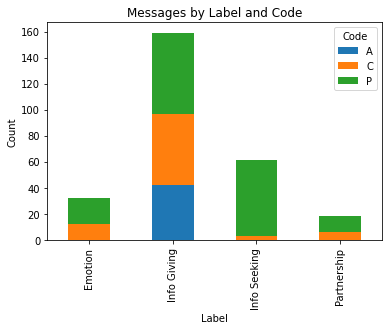

Train_Set_Size:(202, 1000)
Test_Set_Size:(68, 1000)


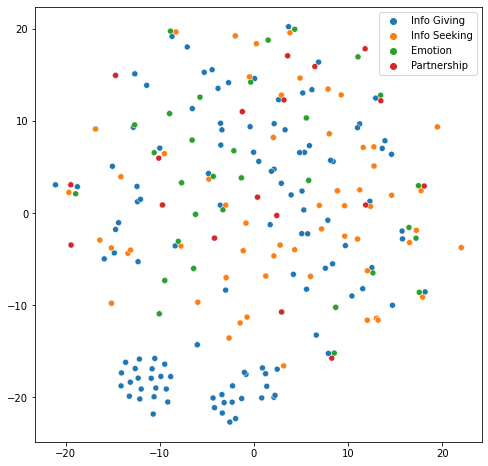

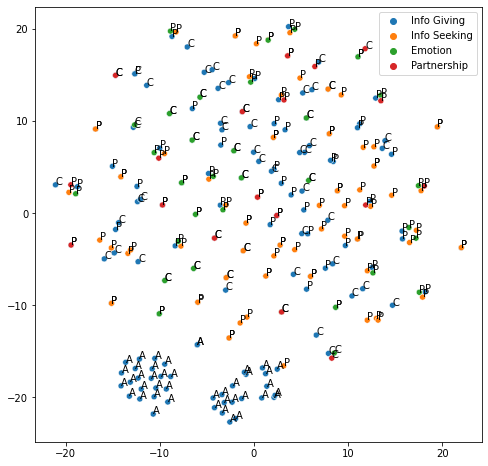

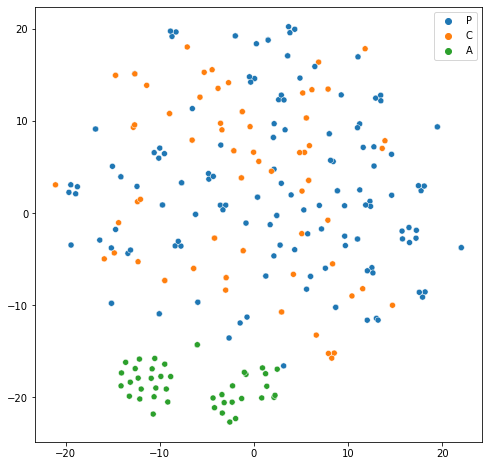

In [3]:
df = pd.read_csv('Data/DataMessageLabelCode.csv')
tfIdfMatrix, data = preprocess_text(df)

# Baseline

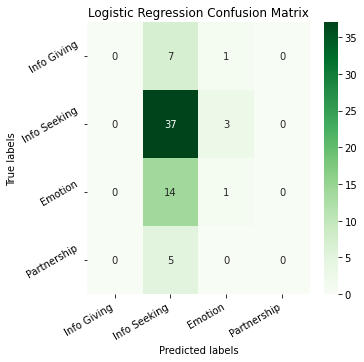

              precision    recall  f1-score   support

 Info Giving       0.59      0.93      0.72        40
Info Seeking       0.20      0.07      0.10        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.56        68
   macro avg       0.20      0.25      0.20        68
weighted avg       0.39      0.56      0.44        68



In [28]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf_lr.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(5,5))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Logistic Regression Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

print(classification_report(y_test,y_test_pred,labels=category_list))

Best hyperparameters: {'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.5991463414634147


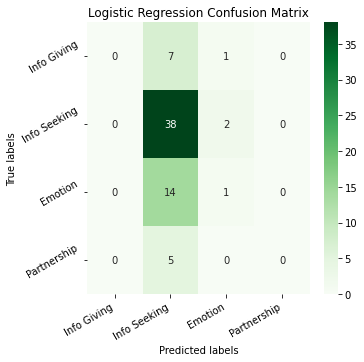

              precision    recall  f1-score   support

 Info Giving       0.59      0.95      0.73        40
Info Seeking       0.25      0.07      0.11        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.57        68
   macro avg       0.21      0.25      0.21        68
weighted avg       0.40      0.57      0.45        68



In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# create the logistic regression classifier
clf_lr = LogisticRegression(random_state=1)

# perform grid search with cross-validation
grid_search = GridSearchCV(clf_lr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# predict using the best estimator
y_test_pred = grid_search.best_estimator_.predict(X_test)

# print the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

labels = category_list
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

print(classification_report(y_test, y_test_pred, labels=category_list))


Best hyperparameters: {'l1_ratio': 0, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.7732894736842104


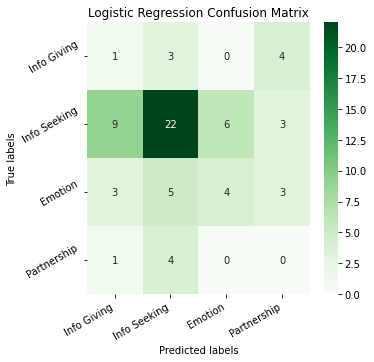

              precision    recall  f1-score   support

 Info Giving       0.65      0.55      0.59        40
Info Seeking       0.40      0.27      0.32        15
     Emotion       0.07      0.12      0.09         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.40        68
   macro avg       0.28      0.24      0.25        68
weighted avg       0.48      0.40      0.43        68



In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# perform SMOTE to handle data imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# create the logistic regression classifier
clf_lr = LogisticRegression(random_state=1)

# perform grid search with cross-validation
grid_search = GridSearchCV(clf_lr, param_grid, cv=5)
grid_search.fit(X_train_res, y_train_res)

# print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# predict using the best estimator
y_test_pred = grid_search.best_estimator_.predict(X_test)

# print the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

labels = category_list
cm = confusion_matrix(y_test, y_test_pred)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

print(classification_report(y_test, y_test_pred, labels=category_list))


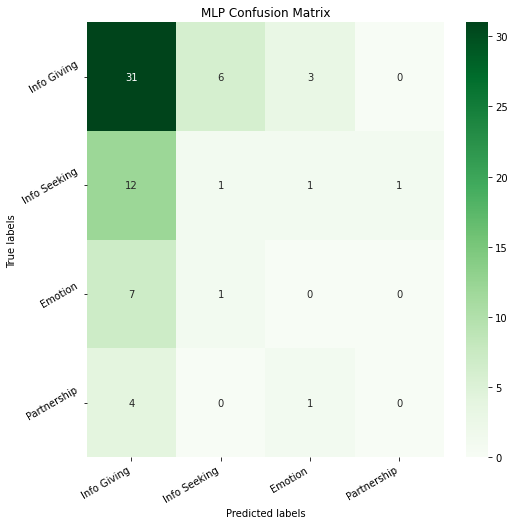

              precision    recall  f1-score   support

 Info Giving       0.57      0.78      0.66        40
Info Seeking       0.12      0.07      0.09        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.47        68
   macro avg       0.17      0.21      0.19        68
weighted avg       0.37      0.47      0.41        68



In [30]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_test_pred= clf_mlp.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('MLP Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

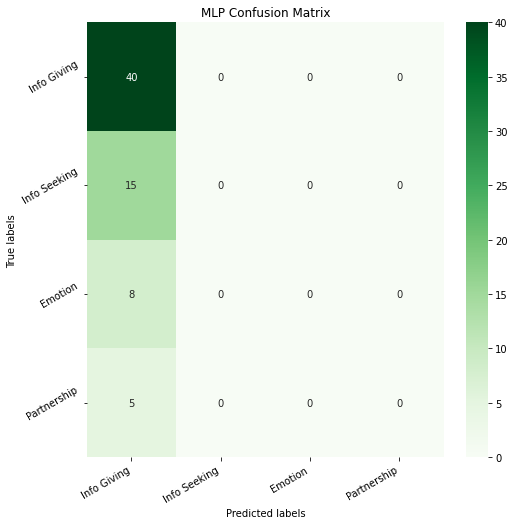

              precision    recall  f1-score   support

 Info Giving       0.59      1.00      0.74        40
Info Seeking       0.00      0.00      0.00        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.59        68
   macro avg       0.15      0.25      0.19        68
weighted avg       0.35      0.59      0.44        68



In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (50,50), (100,50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['adaptive'],
    'max_iter': [200, 300]
}

# Create an MLP classifier
mlp = MLPClassifier(random_state=1)

# Create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the MLP classifier with the best parameters on the training data
clf_mlp = MLPClassifier(random_state=1, **best_params).fit(X_train, y_train)

# Predict on the test data
y_test_pred = clf_mlp.predict(X_test)

# Print the confusion matrix and classification report
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('MLP Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

print(classification_report(y_test, y_test_pred, labels=category_list))

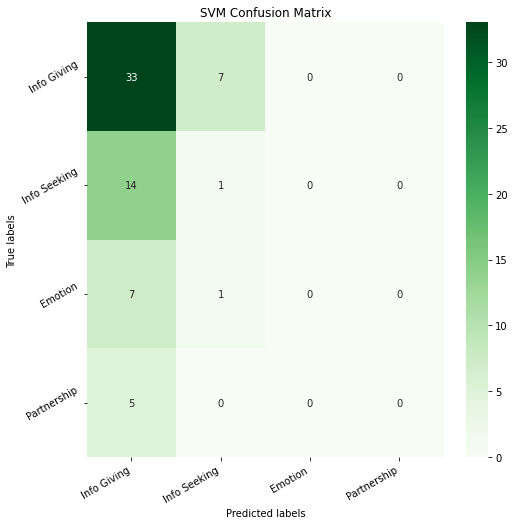

              precision    recall  f1-score   support

 Info Giving       0.56      0.82      0.67        40
Info Seeking       0.11      0.07      0.08        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.50        68
   macro avg       0.17      0.22      0.19        68
weighted avg       0.35      0.50      0.41        68



In [10]:
from sklearn.svm import SVC
clf_svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, break_ties=False).fit(X_train, y_train)
y_test_pred= clf_svm.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('SVM Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

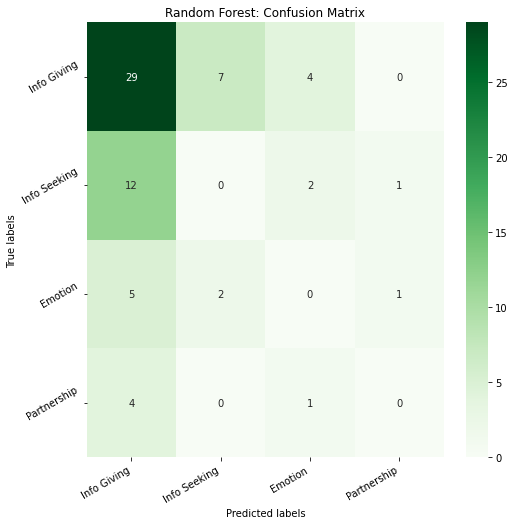

              precision    recall  f1-score   support

 Info Giving       0.58      0.72      0.64        40
Info Seeking       0.00      0.00      0.00        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.43        68
   macro avg       0.14      0.18      0.16        68
weighted avg       0.34      0.43      0.38        68



In [11]:
from sklearn.ensemble import RandomForestClassifier
clf_rc = RandomForestClassifier().fit(X_train, y_train)
y_test_pred= clf_rc.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Random Forest: Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

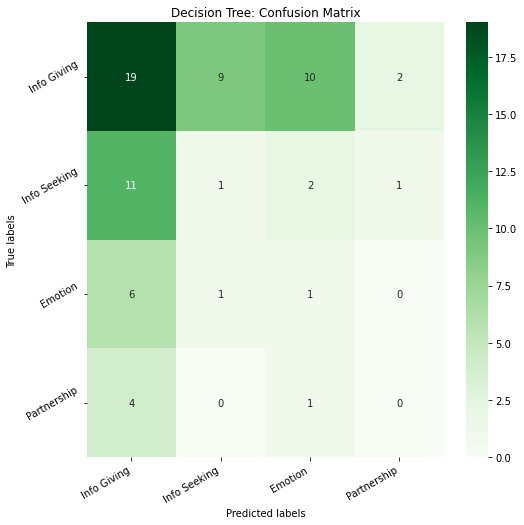

              precision    recall  f1-score   support

 Info Giving       0.47      0.47      0.48        40
Info Seeking       0.09      0.07      0.08        15
     Emotion       0.07      0.12      0.09         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.31        68
   macro avg       0.16      0.17      0.16        68
weighted avg       0.31      0.31      0.31        68



In [13]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier().fit(X_train, y_train)
y_test_pred= clf_dt.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Decision Tree: Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

# Binary Classification Model

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.630
Precision: 0.642
Recall: 0.630
F1-score: 0.561
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.62      0.94      0.75        32
Non-Info-giving       0.67      0.18      0.29        22

       accuracy                           0.63        54
      macro avg       0.65      0.56      0.52        54
   weighted avg       0.64      0.63      0.56        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

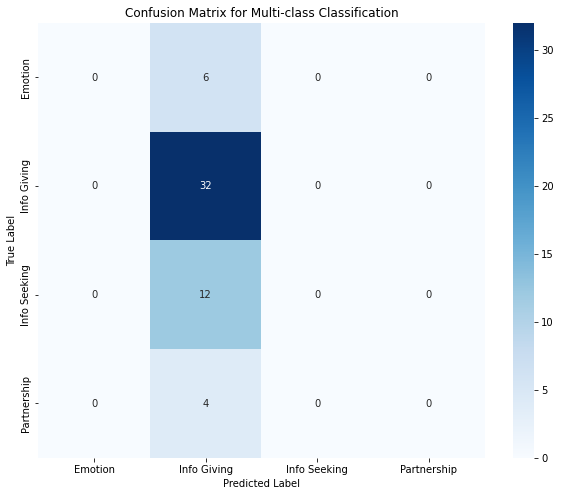

Classification Report:
Accuracy: 0.593
Precision: 0.351
Recall: 0.593
F1-score: 0.441
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.59      1.00      0.74        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.59        54
   macro avg       0.15      0.25      0.19        54
weighted avg       0.35      0.59      0.44        54

Top 200 features:
1 proceed
2 staff
3 trying
4 ok
5 bring
6 coordinate
7 concerned
8 apple
9 symptom
10 amp
11 concluded
12 advise
13 gt
14 type
15 sept
16 coffee
17 coronavirus
18 renewal
19 healthy
20 decreasing
21 ctsim
22 appt
23 stand
24 shot
25 mychart
26 vr
27 pm
28 vimeo
29 luck
30 http
31 took
32 href
33 floor
34 tried
35 supplement
36 message
37 posted
38 think
39 issue
40 sugar
41 pillow
42 mean
43 writing
44 stop
45 heard
46 study
47 lomot

In [20]:
perform_binary_logistic_regression(data, top_k=50)

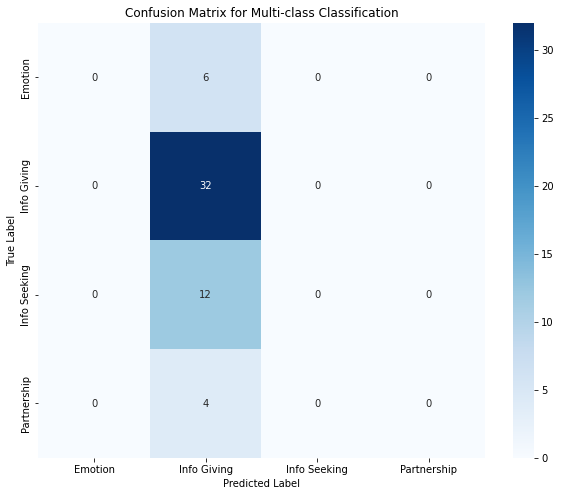

Classification Report:
Accuracy: 0.593
Precision: 0.351
Recall: 0.593
F1-score: 0.441
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.59      1.00      0.74        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.59        54
   macro avg       0.15      0.25      0.19        54
weighted avg       0.35      0.59      0.44        54

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 1664
39 17
40 17th
41 18
42 18th
43 19
44 197
45 1pm
46 1st
47 20
48 200
49 2000
50 2002
51 2003
52 2015
53 2018
54 202
55

In [14]:
perform_logistic_regression(data)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.593
Precision: 0.559
Recall: 0.593
F1-score: 0.496
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.60      0.94      0.73        32
Non-Info-giving       0.50      0.09      0.15        22

       accuracy                           0.59        54
      macro avg       0.55      0.51      0.44        54
   weighted avg       0.56      0.59      0.50        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

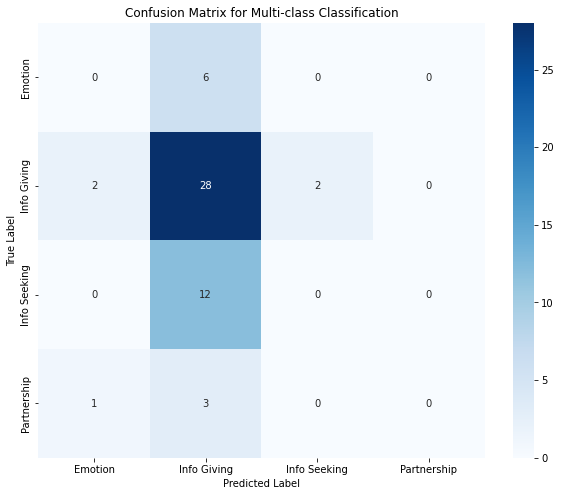

Classification Report:
Accuracy: 0.519
Precision: 0.339
Recall: 0.519
F1-score: 0.410
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.57      0.88      0.69        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.52        54
   macro avg       0.14      0.22      0.17        54
weighted avg       0.34      0.52      0.41        54

Top 200 features:
1 treat
2 sept
3 perscription
4 fall
5 immunotherapy
6 feel
7 supplement
8 uploaded
9 amp
10 vr
11 letter
12 type
13 covid
14 forgot
15 writing
16 com400253143a5b439d1cc
17 date
18 xarelto
19 encouraged
20 update
21 extent
22 authorization
23 android
24 provider
25 http
26 recovery
27 lomotil
28 took
29 morning
30 electively
31 proceed
32 rescheduled
33 trying
34 delaying
35 dawn
36 23rd
37 heart
38 luck
39 dental
40 decided
41 level

In [14]:
perform_binary_decision_tree_classification(data, top_k=50)

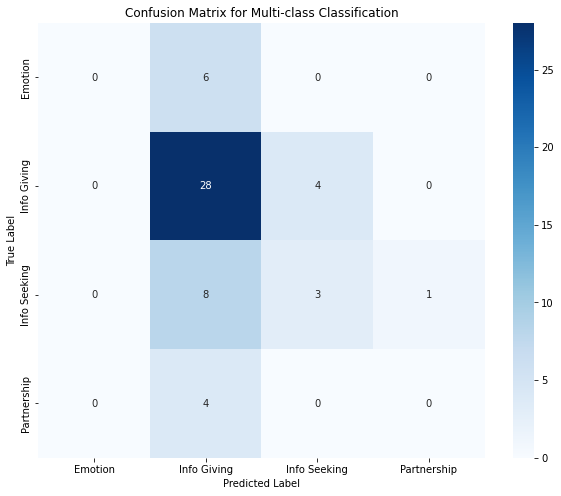

Classification Report:
Accuracy: 0.574
Precision: 0.456
Recall: 0.574
F1-score: 0.496
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.61      0.88      0.72        32
Info Seeking       0.43      0.25      0.32        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.57        54
   macro avg       0.26      0.28      0.26        54
weighted avg       0.46      0.57      0.50        54

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 1664
39 17
40 17th
41 18
42 18th
43 19
44 197
45 1pm
46 1st
47 20
48 200
49 2000
50 2002
51 2003
52 2015
53 2018
54 202
55

In [17]:
perform_decision_tree_classification(data)

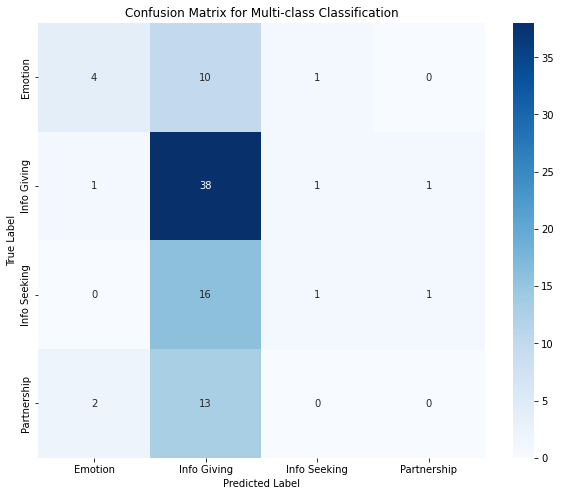

Classification Report:
Accuracy: 0.483
Precision: 0.391
Recall: 0.483
F1-score: 0.377
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.57      0.27      0.36        15
 Info Giving       0.49      0.93      0.64        41
Info Seeking       0.33      0.06      0.10        18
 Partnership       0.00      0.00      0.00        15

    accuracy                           0.48        89
   macro avg       0.35      0.31      0.28        89
weighted avg       0.39      0.48      0.38        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [51]:
perform_random_forest_classification(data)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.630
Precision: 0.628
Recall: 0.630
F1-score: 0.576
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.63      0.91      0.74        32
Non-Info-giving       0.62      0.23      0.33        22

       accuracy                           0.63        54
      macro avg       0.63      0.57      0.54        54
   weighted avg       0.63      0.63      0.58        54

Selected features: android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, http, infected, information, level, lt, moved, mychart, north, pm, prepare, procedure, provider, questionnaire, recovery, scan, smilow, street, surgery, symptom, time, type, video, vimeo, visit, visiting, visitor, visits, wait

Performing binary classification for task: Info-

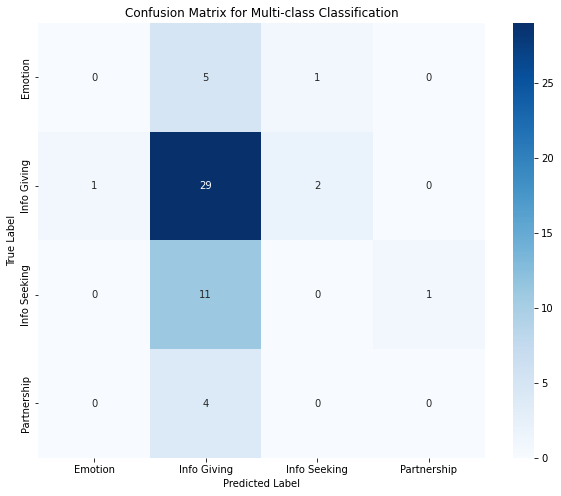

Classification Report:
Accuracy: 0.537
Precision: 0.351
Recall: 0.537
F1-score: 0.424
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.59      0.91      0.72        32
Info Seeking       0.00      0.00      0.00        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.54        54
   macro avg       0.15      0.23      0.18        54
weighted avg       0.35      0.54      0.42        54

Top 200 features:
1 proceed
2 staff
3 trying
4 ok
5 bring
6 coordinate
7 concerned
8 apple
9 symptom
10 amp
11 concluded
12 advise
13 gt
14 type
15 sept
16 coffee
17 coronavirus
18 renewal
19 healthy
20 decreasing
21 ctsim
22 appt
23 stand
24 shot
25 mychart
26 vr
27 pm
28 vimeo
29 luck
30 http
31 took
32 href
33 floor
34 tried
35 supplement
36 message
37 posted
38 think
39 issue
40 sugar
41 pillow
42 mean
43 writing
44 stop
45 heard
46 study
47 lomot

In [3]:
perform_binary_random_forest_classification(data, top_k=50)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.593
Precision: 0.557
Recall: 0.593
F1-score: 0.471
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.60      0.97      0.74        32
Non-Info-giving       0.50      0.05      0.08        22

       accuracy                           0.59        54
      macro avg       0.55      0.51      0.41        54
   weighted avg       0.56      0.59      0.47        54

Selected features: 06473, android, apple, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, coronavirus, covid, dad, date, dawn, department, dept, devine, encouraged, extent, face, floor, gt, haven, href, https, infected, information, levels, lt, masks, moved, mychart, north, pm, prepare, procedure, provider, recovery, scan, smilow, street, symptoms, time, type, video, vimeo, visit, visiting, visitors, visits, wait

Performing binary classification for task: Info-seekin

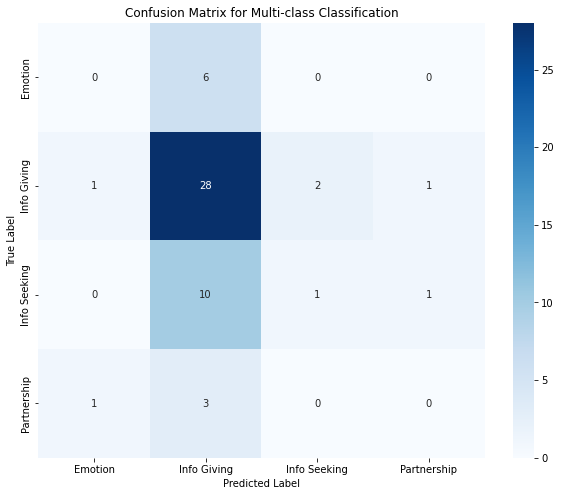

Classification Report:
Accuracy: 0.537
Precision: 0.427
Recall: 0.537
F1-score: 0.450
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00         6
 Info Giving       0.60      0.88      0.71        32
Info Seeking       0.33      0.08      0.13        12
 Partnership       0.00      0.00      0.00         4

    accuracy                           0.54        54
   macro avg       0.23      0.24      0.21        54
weighted avg       0.43      0.54      0.45        54

Top 200 features:
1 06473
2 doses
3 proceed
4 staff
5 trying
6 ok
7 bring
8 coordinate
9 masks
10 apple
11 concerned
12 amp
13 concluded
14 9871
15 gt
16 type
17 coffee
18 coronavirus
19 renewal
20 healthy
21 decreasing
22 ctsim
23 appt
24 patient
25 shot
26 stand
27 mychart
28 vr
29 pm
30 vimeo
31 luck
32 took
33 href
34 floor
35 tried
36 supplements
37 https
38 orders
39 think
40 issue
41 sugar
42 pillow
43 mean
44 writing
45 stop
46 levels
47 heard

In [10]:
perform_binary_gradient_boosting_classification(df, top_k=50)

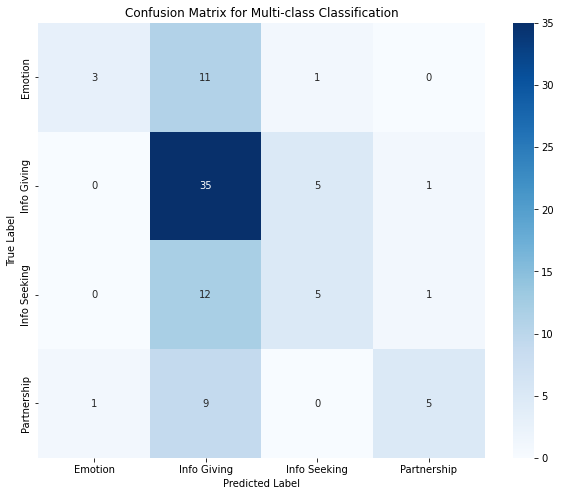

Classification Report:
Accuracy: 0.539
Precision: 0.579
Recall: 0.539
F1-score: 0.498
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.75      0.20      0.32        15
 Info Giving       0.52      0.85      0.65        41
Info Seeking       0.45      0.28      0.34        18
 Partnership       0.71      0.33      0.45        15

    accuracy                           0.54        89
   macro avg       0.61      0.42      0.44        89
weighted avg       0.58      0.54      0.50        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [50]:
perform_gradient_boosting_classification(df)

# Use chatgpt to generate more samples

Number of sentences in transcriptions column: 478
Number of unique words in transcriptions column: 939
===========Original Categories =======================
Cat:1 Emotion : 43
Cat:2 Info Giving : 43
Cat:3 Info Seeking : 28
Cat:4 Partnership : 59
============Reduced Categories ======================
Cat:1 Emotion : 43
Cat:2 Info Giving : 43
Cat:3 Info Seeking : 28
Cat:4 Partnership : 59
============ Reduced Categories ======================


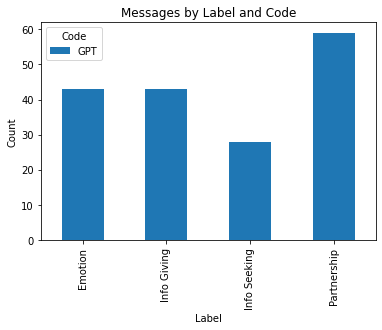

Train_Set_Size:(129, 1000)
Test_Set_Size:(44, 1000)


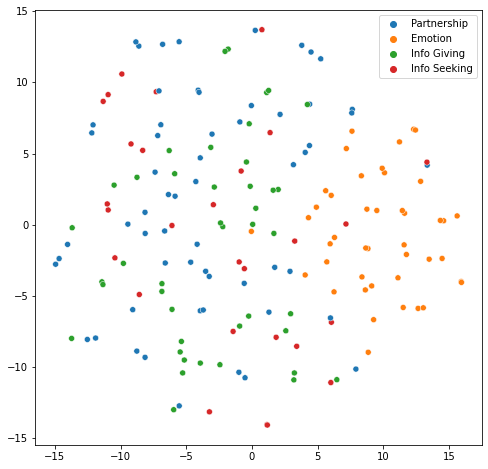

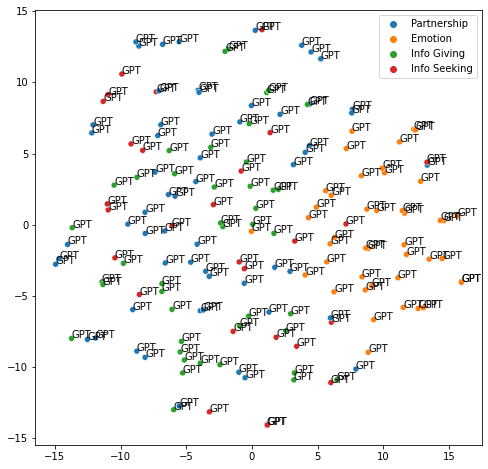

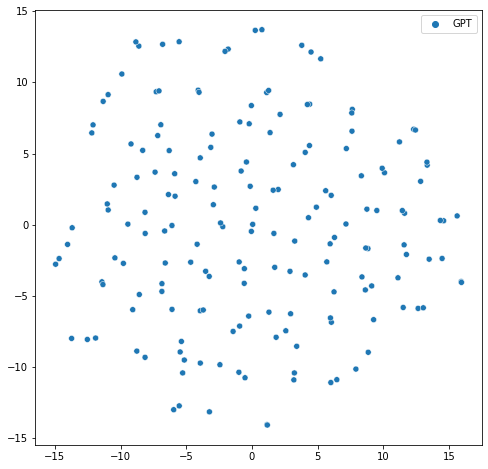

In [4]:
# Use chatgpt to generate more samples
df_gpt = pd.read_csv('Data/GPTMessageLabelCode.csv')
tfidf_matrix_gpt, data_gpt = preprocess_text(df_gpt)

Number of sentences in transcriptions column: 748
Number of unique words in transcriptions column: 2049
===========Original Categories =======================
Cat:1 Emotion : 75
Cat:2 Info Giving : 202
Cat:3 Info Seeking : 89
Cat:4 Partnership : 77
============Reduced Categories ======================
Cat:1 Emotion : 75
Cat:2 Info Giving : 202
Cat:3 Info Seeking : 89
Cat:4 Partnership : 77
============ Reduced Categories ======================


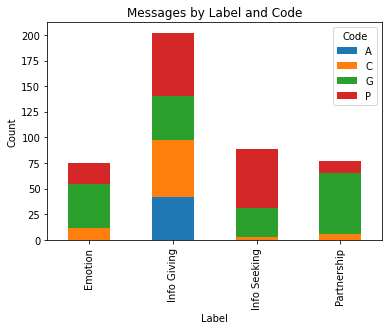

Train_Set_Size:(332, 1000)
Test_Set_Size:(111, 1000)


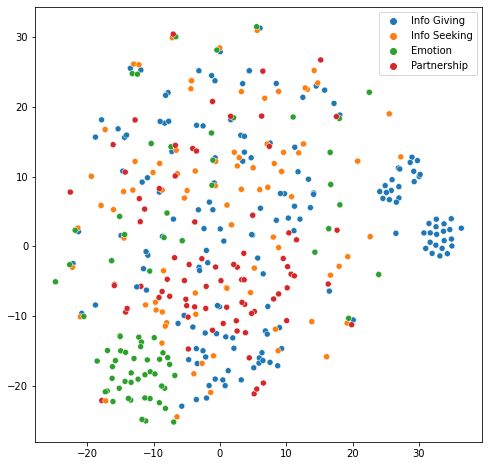

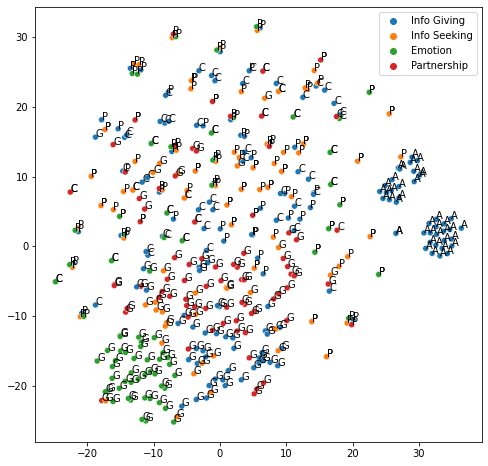

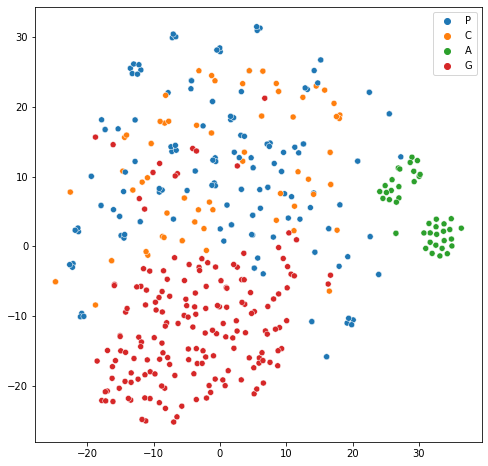

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
                                                Message Code        Label
 0    197 I noticed medication list updated I n't gi...    P  Info Giving
 1    Blood urine stool- began yesterday We also not...    P  Info Giving
 2         Can someone set appointment I way contact Dr    P  Info Giving
 3    Dear Doctor Lacy I told daughter getting treat...    P  Info Giving
 4    Dear Dr Chiang When I saw last Thursday ( May ...    P  Info Giving
 ..                                                 ...  ...          ...
 438  6 . Dr. Thompson , mother 's blood sugar level...    G  Partnership
 439  7 . Hello Dr. Kim , I recently blood test done...    G  Partnership
 440  8 . Dear Dr. Brown , I wanted follow MRI resul...    G  Partnership
 441  9 . H

In [5]:
# Combine df and df_combined
df_combined = pd.concat([df, df_gpt], ignore_index=True)
data_combined = pd.concat([data, data_gpt], ignore_index=True)
df_combined = df_combined[df_combined['Message'].notna()]
replacements = {'Auto': 'A', 'Patient': 'P', 'Clinician': 'C', 'GPT': 'G'}

# replace the values in the specified column
df_combined['Code'] = df_combined['Code'].replace(replacements)
preprocess_text(df_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.663
Precision: 0.703
Recall: 0.663
F1-score: 0.633
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.79      0.37      0.50        41
Non-Info-giving       0.63      0.92      0.75        48

       accuracy                           0.66        89
      macro avg       0.71      0.64      0.62        89
   weighted avg       0.70      0.66      0.63        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

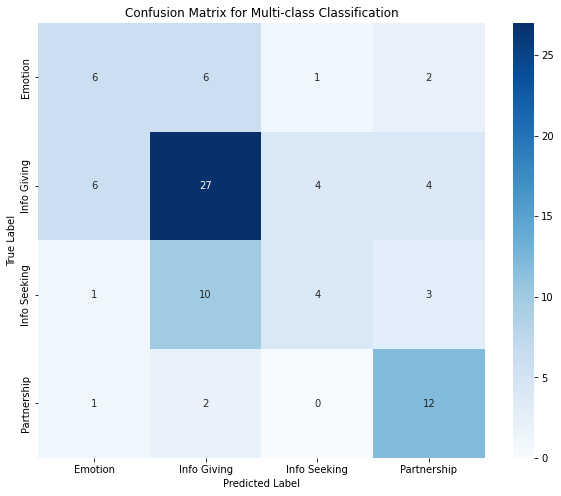

Classification Report:
Accuracy: 0.551
Precision: 0.535
Recall: 0.551
F1-score: 0.531
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.43      0.40      0.41        15
 Info Giving       0.60      0.66      0.63        41
Info Seeking       0.44      0.22      0.30        18
 Partnership       0.57      0.80      0.67        15

    accuracy                           0.55        89
   macro avg       0.51      0.52      0.50        89
weighted avg       0.53      0.55      0.53        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [6]:
perform_binary_logistic_regression(data_combined, top_k=50)

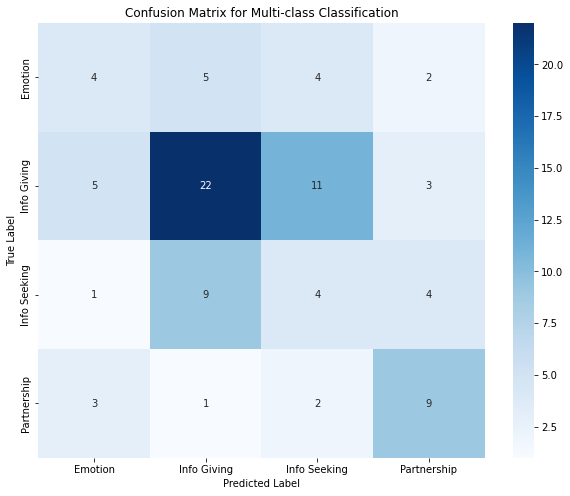

Classification Report:
Accuracy: 0.438
Precision: 0.449
Recall: 0.438
F1-score: 0.441
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.31      0.27      0.29        15
 Info Giving       0.59      0.54      0.56        41
Info Seeking       0.19      0.22      0.21        18
 Partnership       0.50      0.60      0.55        15

    accuracy                           0.44        89
   macro avg       0.40      0.41      0.40        89
weighted avg       0.45      0.44      0.44        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [21]:
perform_logistic_regression(data_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.663
Precision: 0.705
Recall: 0.663
F1-score: 0.654
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.59      0.85      0.70        41
Non-Info-giving       0.80      0.50      0.62        48

       accuracy                           0.66        89
      macro avg       0.70      0.68      0.66        89
   weighted avg       0.70      0.66      0.65        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

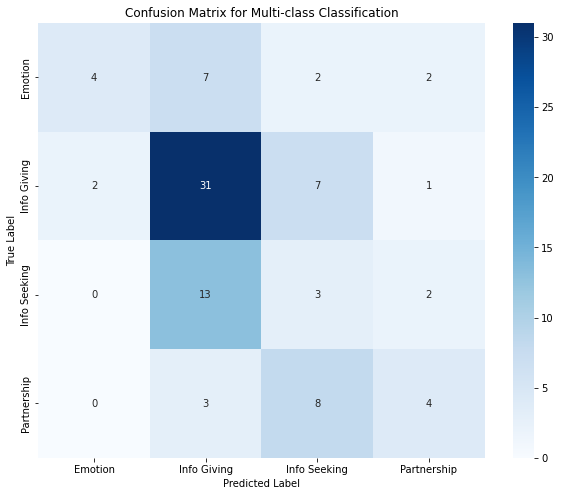

Classification Report:
Accuracy: 0.472
Precision: 0.482
Recall: 0.472
F1-score: 0.453
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.67      0.27      0.38        15
 Info Giving       0.57      0.76      0.65        41
Info Seeking       0.15      0.17      0.16        18
 Partnership       0.44      0.27      0.33        15

    accuracy                           0.47        89
   macro avg       0.46      0.36      0.38        89
weighted avg       0.48      0.47      0.45        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [7]:
perform_binary_decision_tree_classification(data_combined, top_k=50)

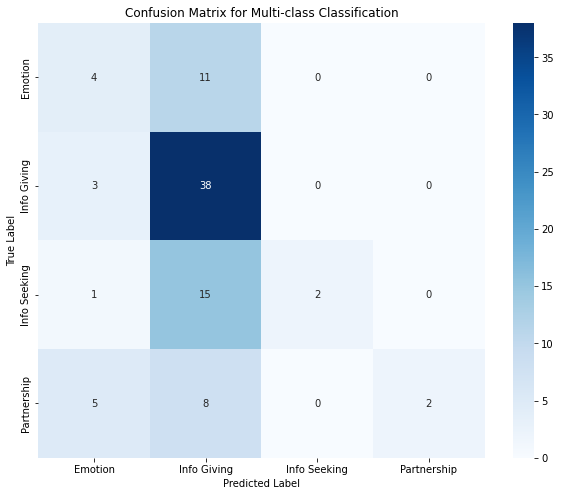

Classification Report:
Accuracy: 0.517
Precision: 0.666
Recall: 0.517
F1-score: 0.438
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.31      0.27      0.29        15
 Info Giving       0.53      0.93      0.67        41
Info Seeking       1.00      0.11      0.20        18
 Partnership       1.00      0.13      0.24        15

    accuracy                           0.52        89
   macro avg       0.71      0.36      0.35        89
weighted avg       0.67      0.52      0.44        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [22]:
perform_decision_tree_classification(data_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.685
Precision: 0.742
Recall: 0.685
F1-score: 0.675
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.61      0.90      0.73        41
Non-Info-giving       0.86      0.50      0.63        48

       accuracy                           0.69        89
      macro avg       0.73      0.70      0.68        89
   weighted avg       0.74      0.69      0.67        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

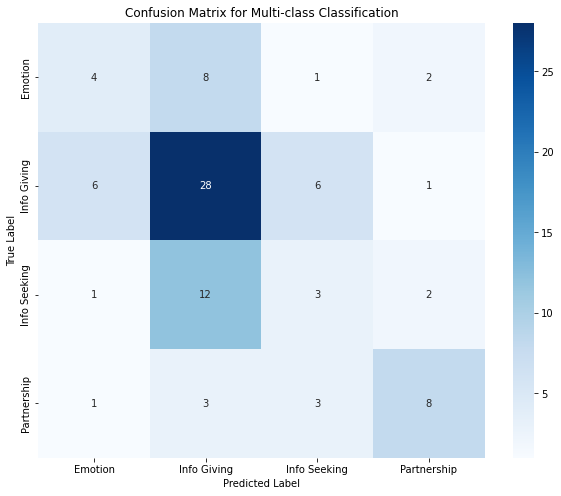

Classification Report:
Accuracy: 0.483
Precision: 0.459
Recall: 0.483
F1-score: 0.466
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.33      0.27      0.30        15
 Info Giving       0.55      0.68      0.61        41
Info Seeking       0.23      0.17      0.19        18
 Partnership       0.62      0.53      0.57        15

    accuracy                           0.48        89
   macro avg       0.43      0.41      0.42        89
weighted avg       0.46      0.48      0.47        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [8]:
perform_binary_random_forest_classification(data_combined, top_k=50)

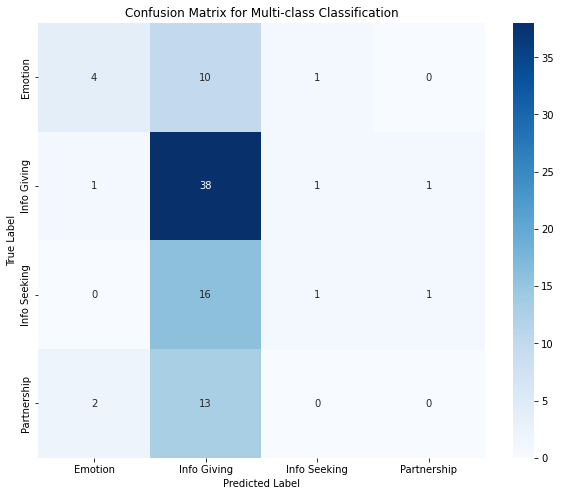

Classification Report:
Accuracy: 0.483
Precision: 0.391
Recall: 0.483
F1-score: 0.377
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.57      0.27      0.36        15
 Info Giving       0.49      0.93      0.64        41
Info Seeking       0.33      0.06      0.10        18
 Partnership       0.00      0.00      0.00        15

    accuracy                           0.48        89
   macro avg       0.35      0.31      0.28        89
weighted avg       0.39      0.48      0.38        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [23]:
perform_random_forest_classification(data_combined)

Performing binary classification for task: Info-giving vs. Non-Info-giving
Accuracy: 0.685
Precision: 0.751
Recall: 0.685
F1-score: 0.652
Classification Report:
                  precision    recall  f1-score   support

    Info Giving       0.88      0.37      0.52        41
Non-Info-giving       0.64      0.96      0.77        48

       accuracy                           0.69        89
      macro avg       0.76      0.66      0.64        89
   weighted avg       0.75      0.69      0.65        89

Selected features: advice, android, apple, appreciate, appt, bring, cancel, com400253143a5b439d1cc, com4002532083e3d356236, condition, cope, coronavirus, covid, date, dept, devine, encouraged, extent, face, floor, group, gt, guidance, haven, href, http, infected, lt, md, moved, mychart, new, north, pm, prepare, provide, provider, questionnaire, resource, smilow, street, support, type, video, vimeo, visit, visiting, visitor, visits, wanted

Performing binary classification for task: Info-s

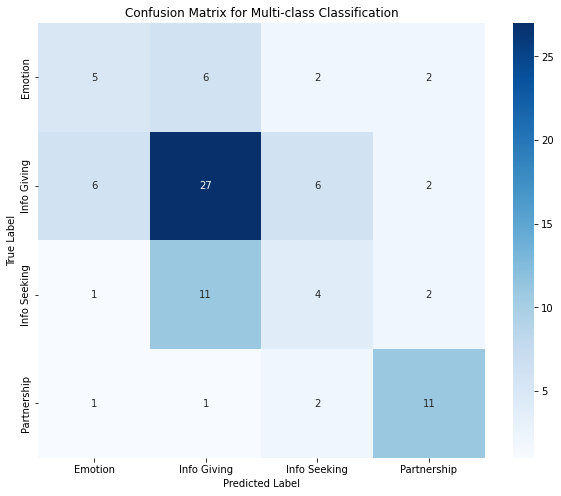

Classification Report:
Accuracy: 0.528
Precision: 0.508
Recall: 0.528
F1-score: 0.516
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.38      0.33      0.36        15
 Info Giving       0.60      0.66      0.63        41
Info Seeking       0.29      0.22      0.25        18
 Partnership       0.65      0.73      0.69        15

    accuracy                           0.53        89
   macro avg       0.48      0.49      0.48        89
weighted avg       0.51      0.53      0.52        89

Top 200 features:
1 locate
2 lomotil
3 recommendation
4 questionnaire
5 stress
6 anxiety
7 prepare
8 covid
9 new
10 necessary
11 extent
12 store
13 risk
14 luck
15 md
16 expertise
17 face
18 improvement
19 port
20 considering
21 visitor
22 resolving
23 alternative
24 provider
25 determine
26 href
27 traveling
28 starting
29 lt
30 parker
31 june
32 cope
33 scheduling
34 simmons
35 struggling
36 opinion
37 frequency
38 avoid
39 scheduled
40 smilow
41 22

In [9]:
perform_binary_gradient_boosting_classification(data_combined, top_k=50)

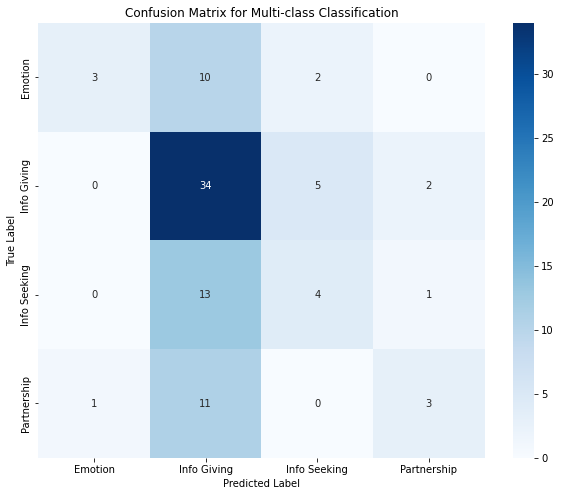

Classification Report:
Accuracy: 0.494
Precision: 0.515
Recall: 0.494
F1-score: 0.445
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.75      0.20      0.32        15
 Info Giving       0.50      0.83      0.62        41
Info Seeking       0.36      0.22      0.28        18
 Partnership       0.50      0.20      0.29        15

    accuracy                           0.49        89
   macro avg       0.53      0.36      0.38        89
weighted avg       0.51      0.49      0.44        89

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [24]:
perform_gradient_boosting_classification(data_combined)

In [43]:
df_eda = pd.read_csv('Data/augmented_data.csv', index_col=0)
df_eda.columns = ['Message', 'Label']
df_eda["Code"] = "EDA"
df_eda = df_eda.loc[list(df_eda.loc[:,"Label"] != "SDM"), :]

Number of sentences in transcriptions column: 338
Number of unique words in transcriptions column: 1715
===========Original Categories =======================
Cat:1 Emotion : 64
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 54
============Reduced Categories ======================
Cat:1 Emotion : 64
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 54
============ Reduced Categories ======================


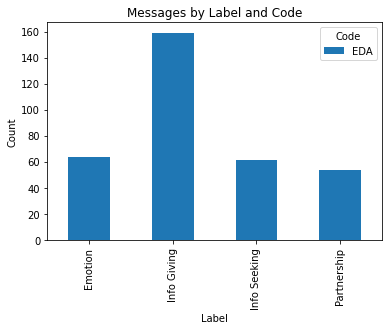

Train_Set_Size:(253, 1000)
Test_Set_Size:(85, 1000)


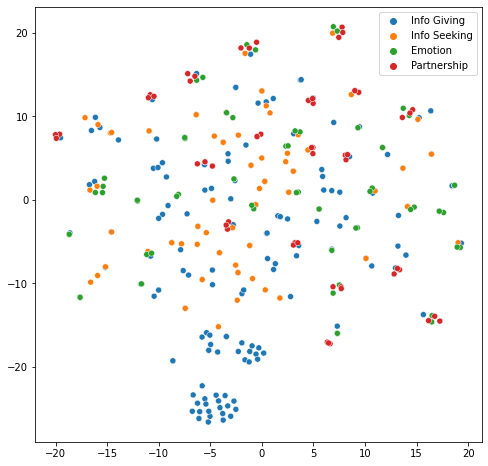

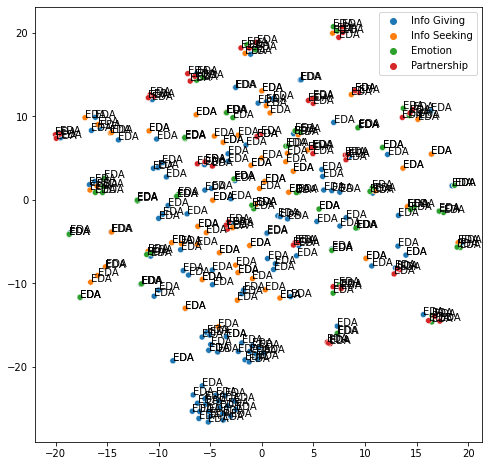

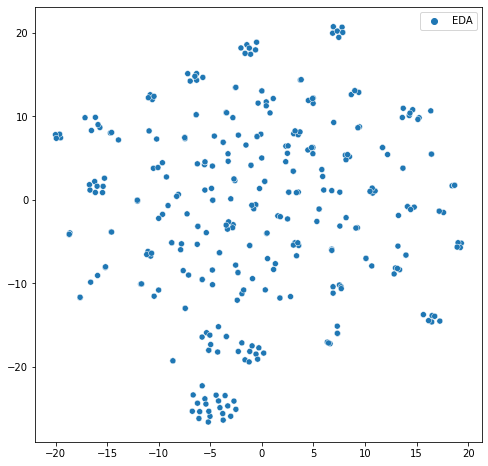

Number of sentences in transcriptions column: 1086
Number of unique words in transcriptions column: 2236
===========Original Categories =======================
Cat:1 Emotion : 139
Cat:2 Info Giving : 361
Cat:3 Info Seeking : 150
Cat:4 Partnership : 131
============Reduced Categories ======================
Cat:1 Emotion : 139
Cat:2 Info Giving : 361
Cat:3 Info Seeking : 150
Cat:4 Partnership : 131
============ Reduced Categories ======================


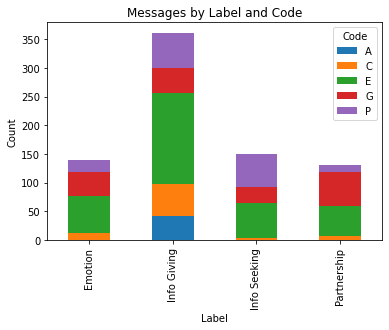

Train_Set_Size:(585, 1000)
Test_Set_Size:(196, 1000)


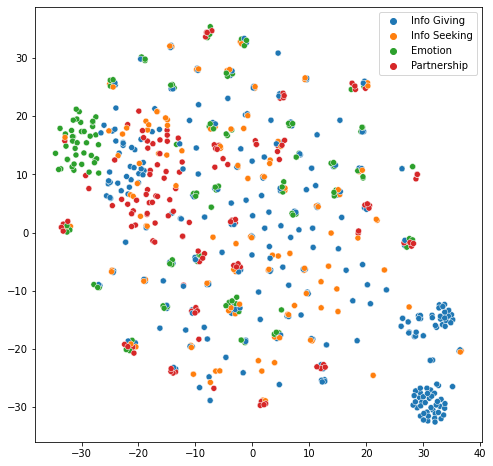

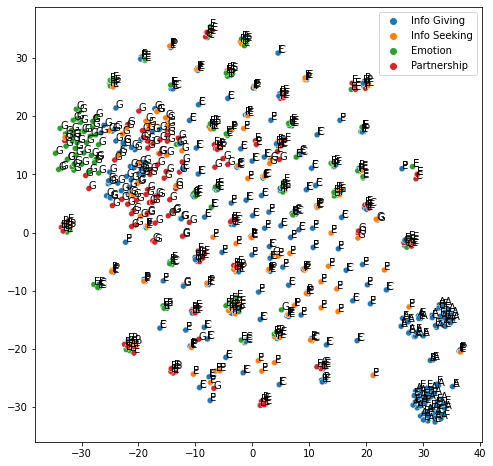

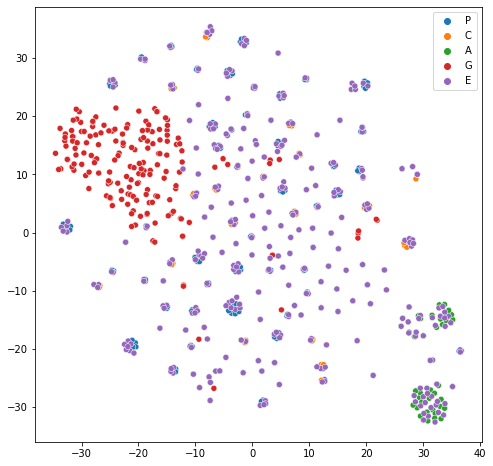

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
                                                Message Code        Label
 0    197 I noticed medication list updated I n't gi...    P  Info Giving
 1    Blood urine stool- began yesterday We also not...    P  Info Giving
 2         Can someone set appointment I way contact Dr    P  Info Giving
 3    Dear Doctor Lacy I told daughter getting treat...    P  Info Giving
 4    Dear Dr Chiang When I saw last Thursday ( May ...    P  Info Giving
 ..                                                 ...  ...          ...
 776  dear dr business office chiang bequeath saw th...    E  Partnership
 777  dear dr chiang saw last thursday may expected ...    E  Partnership
 778  blood testing done yesterday vernon noticed fo...    E  Partnership
 779  blood

In [46]:
tfIdfMatrix_eda, data_eda = preprocess_text(df_eda)
# Combine df and df_combined
df_final = pd.concat([df_combined, df_eda], ignore_index=True)
data_final = pd.concat([data_combined, data_eda], ignore_index=True)
replacements = {'Auto': 'A', 'Patient': 'P', 'Clinician': 'C', 'GPT': 'G', "EDA": "E"}

# replace the values in the specified column
df_final['Code'] = df_final['Code'].replace(replacements)
preprocess_text(df_final)

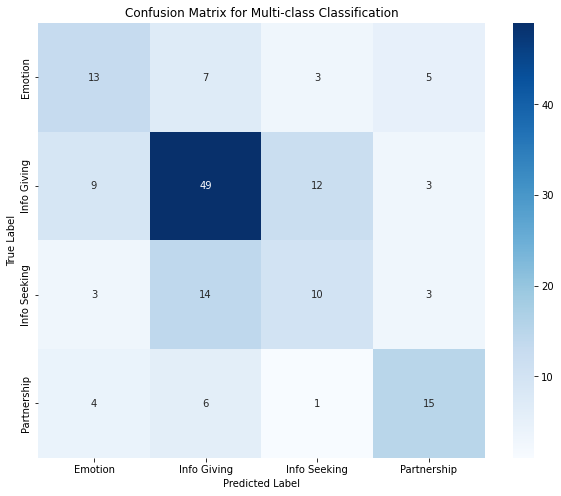

Classification Report:
Accuracy: 0.554
Precision: 0.549
Recall: 0.554
F1-score: 0.551
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.45      0.46      0.46        28
 Info Giving       0.64      0.67      0.66        73
Info Seeking       0.38      0.33      0.36        30
 Partnership       0.58      0.58      0.58        26

    accuracy                           0.55       157
   macro avg       0.51      0.51      0.51       157
weighted avg       0.55      0.55      0.55       157

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [48]:
perform_logistic_regression(data_final)

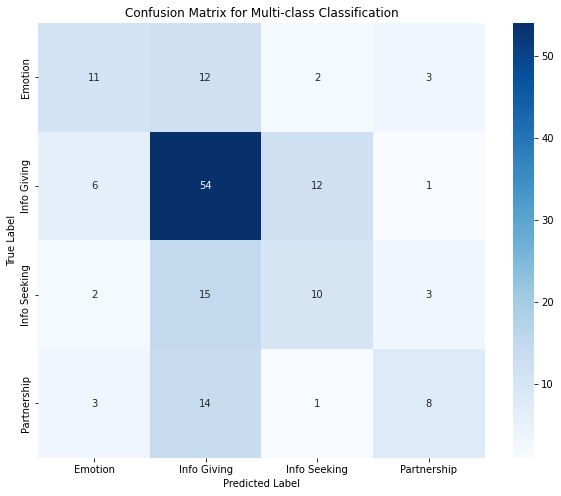

Classification Report:
Accuracy: 0.529
Precision: 0.518
Recall: 0.529
F1-score: 0.511
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.50      0.39      0.44        28
 Info Giving       0.57      0.74      0.64        73
Info Seeking       0.40      0.33      0.36        30
 Partnership       0.53      0.31      0.39        26

    accuracy                           0.53       157
   macro avg       0.50      0.44      0.46       157
weighted avg       0.52      0.53      0.51       157

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [49]:
perform_decision_tree_classification(data_final)

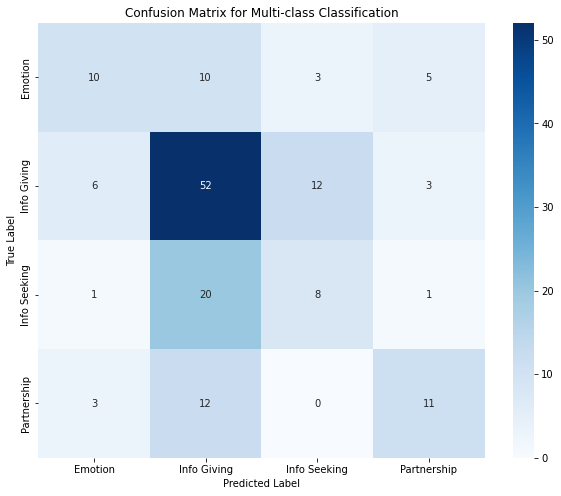

Classification Report:
Accuracy: 0.516
Precision: 0.504
Recall: 0.516
F1-score: 0.501
Classification Report:
               precision    recall  f1-score   support

     Emotion       0.50      0.36      0.42        28
 Info Giving       0.55      0.71      0.62        73
Info Seeking       0.35      0.27      0.30        30
 Partnership       0.55      0.42      0.48        26

    accuracy                           0.52       157
   macro avg       0.49      0.44      0.45       157
weighted avg       0.50      0.52      0.50       157

Top 200 features:
1 00
2 01032011
3 04
4 04042018
5 04262018
6 05172017
7 06272015
8 0630
9 06473
10 06477
11 06510
12 0670
13 06824
14 06830
15 10
16 100
17 1011
18 1095
19 10th
20 11
21 111
22 111417
23 11142017
24 1115
25 11th
26 12
27 1200jco
28 1223
29 12th
30 13
31 14
32 1406014136
33 14070
34 14282
35 14th
36 15
37 150mg
38 16
39 1664
40 17
41 17th
42 18
43 18th
44 19
45 197
46 198
47 199
48 1pm
49 1st
50 20
51 200
52 2000
53 2002
54 2003
55 20

In [47]:
perform_random_forest_classification(data_final)